In [1]:
# !pip install pandas
# !pip install statsmodels
# !pip install lightgbm
# !pip install gensim
# !pip install scipy==1.11.0
# !pip install matplotlib

In [2]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle 
from numpy import triu
from scipy.linalg import get_blas_funcs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

# from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [3]:
# general settings
class CFG:
    data_folder = '../SAP_AI/Demand Forecasting/Datasets/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [4]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [5]:
import os
print(os.getcwd())

/home/user/projects/SAP_AI/Demand Forecasting/notebooks


In [6]:
file_path = '/home/user/projects/SAP_AI/Demand Forecasting/Datasets/sales_train_validation.csv'
xdat = pd.read_csv(file_path)
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [7]:
print(xdat.dtypes)

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object


In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


xdat = reduce_mem_usage(xdat)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [9]:
xdat.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

In [10]:
# melt the data into long format
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()

# get proper timestamps
file_path = '/home/user/projects/SAP_AI/Demand Forecasting/Datasets/'
xcal = pd.read_csv(file_path+'calendar.csv')

In [11]:
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [12]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1', 
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'], 
                  axis = 1, inplace = True)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


In [13]:
# Ensure that 'date' column is in datetime format
xdat['date'] = pd.to_datetime(xdat['date'])

# Add five years using DateOffset
xdat['date'] = xdat['date'] + pd.DateOffset(years=8)

# Display the updated DataFrame
print(xdat)


                                     id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
23330943    FOODS_3_823_CA_4_validation    FOODS_3_823    FOODS_3    FOODS   
23330944    FOODS_3_824_CA_4_validation    FOODS_3_824    FOODS_3    FOODS   
23330945    FOODS_3_825_CA_4_validation    FOODS_3_825    FOODS_3    FOODS   
23330946    FOODS_3_826_CA_4_validation    FOODS_3_826    FOODS_3    FOODS   
23330947    FOODS_3_827_CA_4_validation    FOODS_3_827    FOODS_3    FOODS   

         store_id  sales       date  wday  snap_CA  
0         

Croston Model 

<Axes: xlabel='date'>

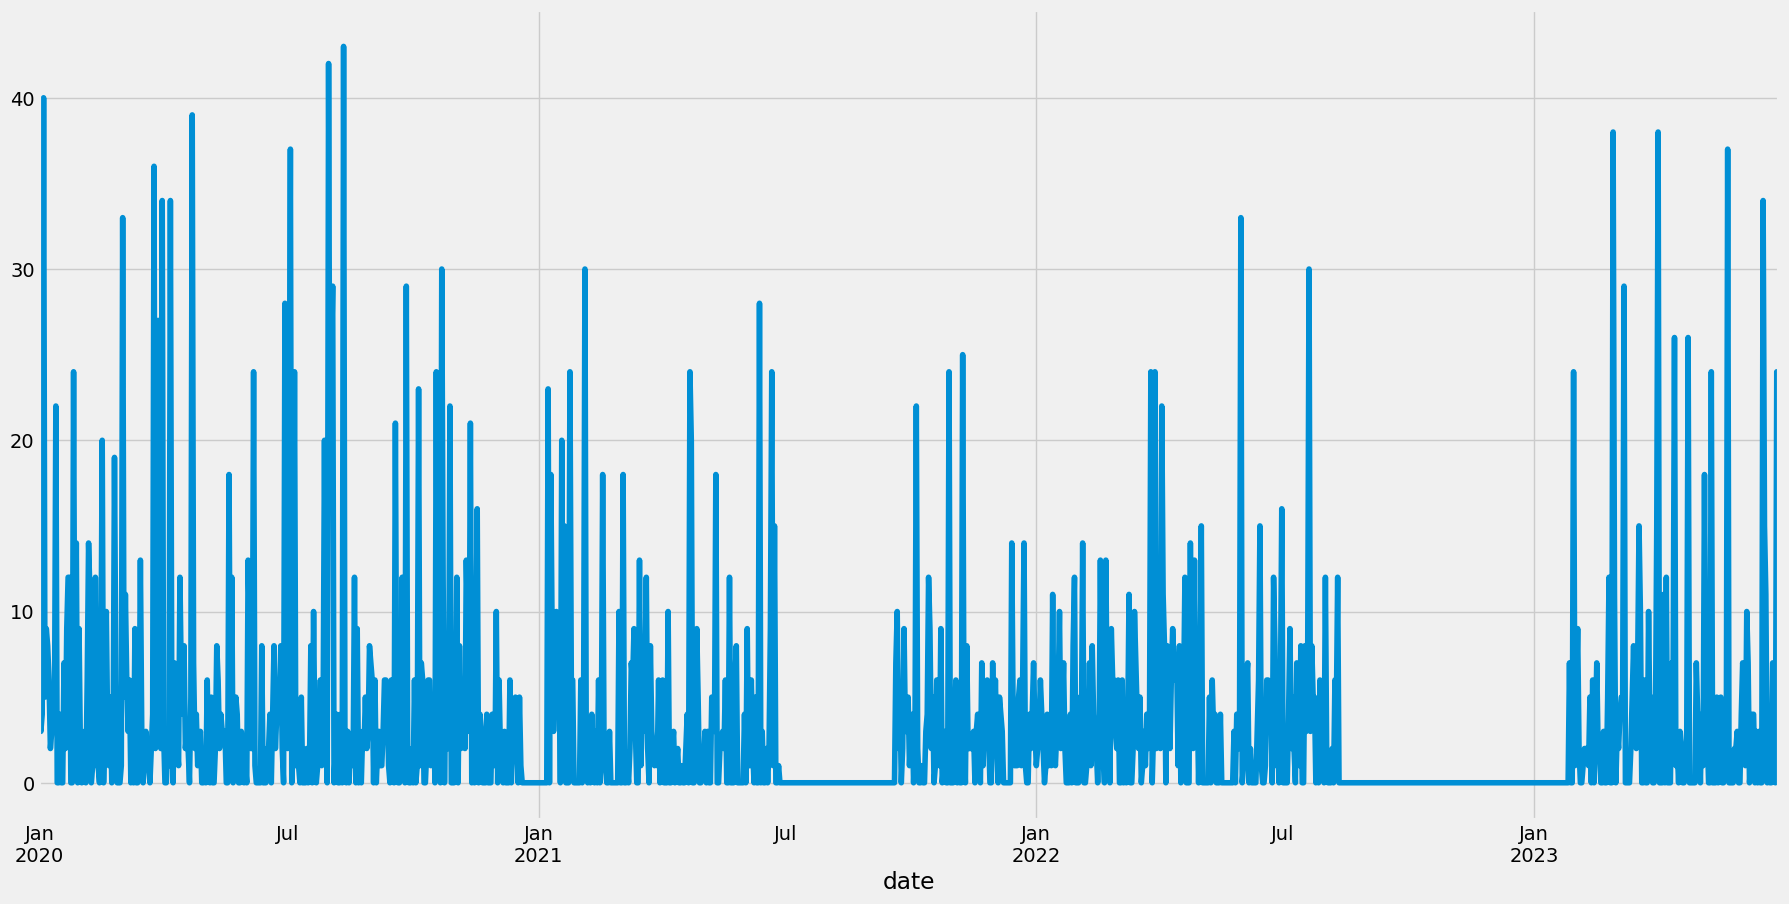

In [14]:
df = xdat.loc[(xdat.item_id == 'HOBBIES_1_288') & (xdat.store_id == 'CA_1') ][['date', 'sales']].copy()
df = df.loc[(df.date >= '2020-01-01') & (df.date <= '2023-06-30')]
df.set_index('date').sales.plot()

In [15]:
def Croston(ts,extra_periods=1,alpha=0.4):
    
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [16]:
pred_croston =  Croston(df.sales, extra_periods = 10)
pred_croston

,Demand,Forecast,Period,Level,Error
0,5.0,5.000000,1.000000,5.000000,0.000
1,3.0,5.000000,1.000000,5.000000,-2.000
2,4.0,4.200000,1.000000,4.200000,-0.200
3,40.0,4.120000,1.000000,4.120000,35.880
4,5.0,18.472000,1.000000,18.472000,-13.472
...,...,...,...,...,...
1282,NaN,5.050468,1.299267,6.561904,NaN
1283,NaN,5.050468,1.299267,6.561904,NaN
1284,NaN,5.050468,1.299267,6.561904,NaN
1285,NaN,5.050468,1.299267,6.561904,NaN


In [17]:
pred_croston = pred_croston.Forecast.head(len(df))

print('RMSE: ' + str(my_rmse(df.sales,pred_croston)))

RMSE: 6.9581


<Axes: xlabel='date'>

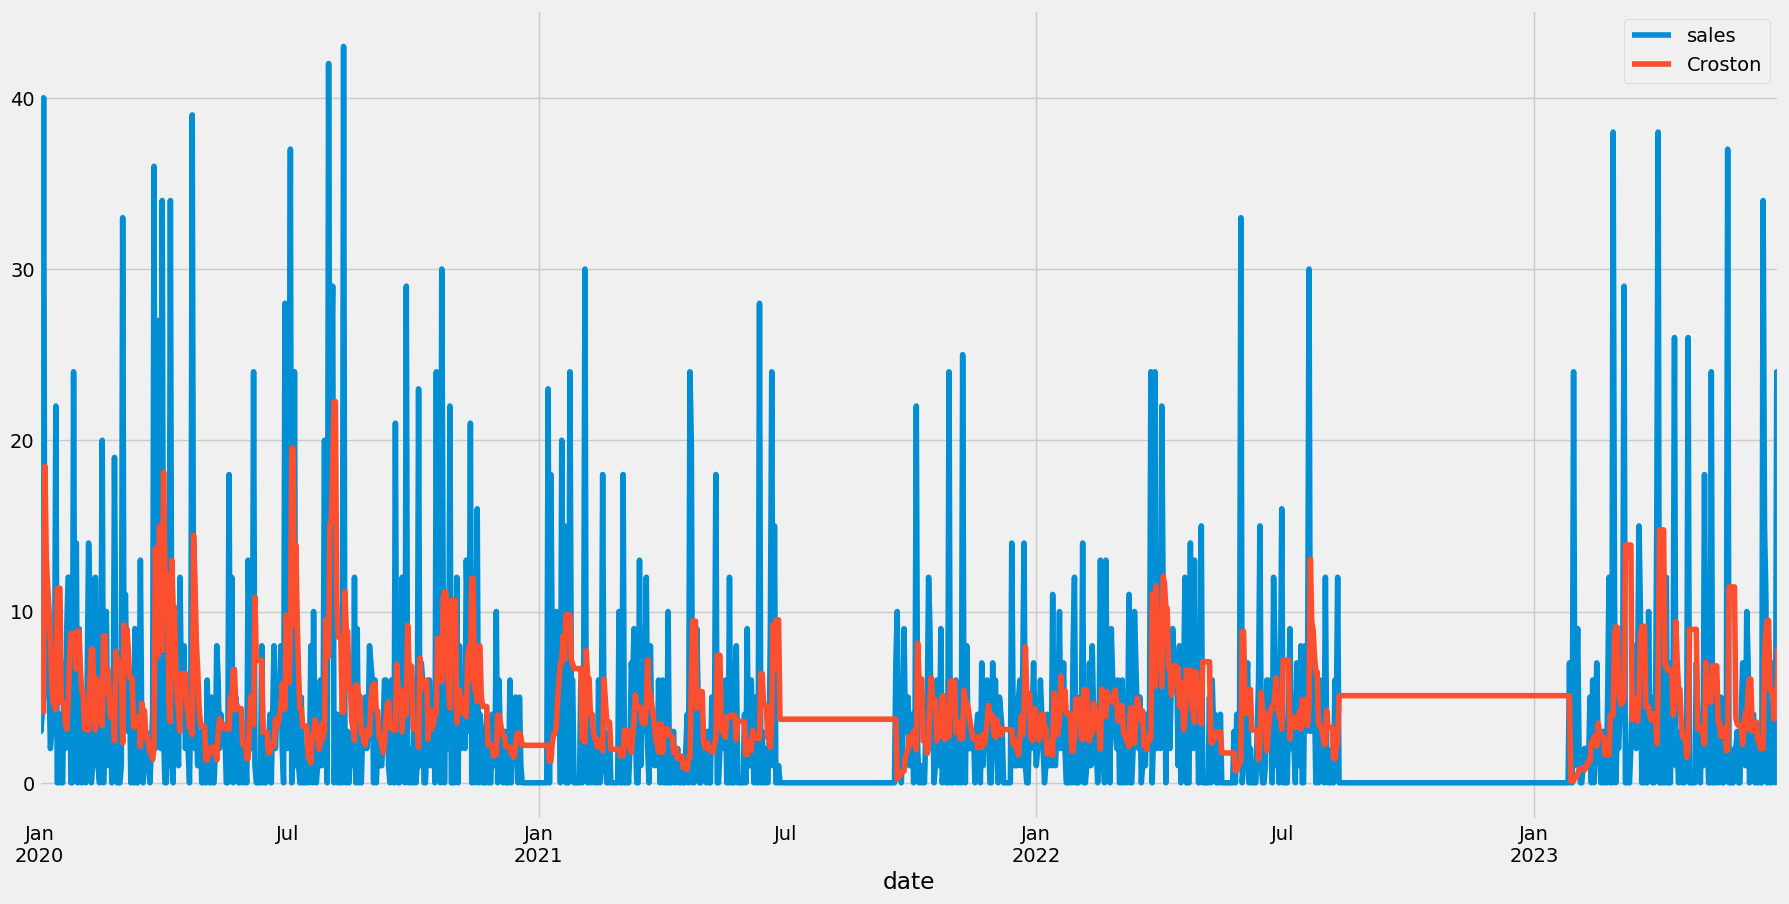

In [18]:
# xvalid = pd.DataFrame(xvalid.values, columns = ['actual'])
df['Croston'] = pred_croston.values
df.set_index('date').plot()

In [19]:
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.1):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [20]:
pred_croston_tsb =  Croston_TSB(df.sales, extra_periods = 10, alpha = 0.1, beta = 0.1)

pred_croston_tsb = pred_croston_tsb.Forecast.head(len(df))
print('RMSE: ' + str(my_rmse(df.sales,pred_croston_tsb)))

RMSE: 6.1255


<Axes: xlabel='date'>

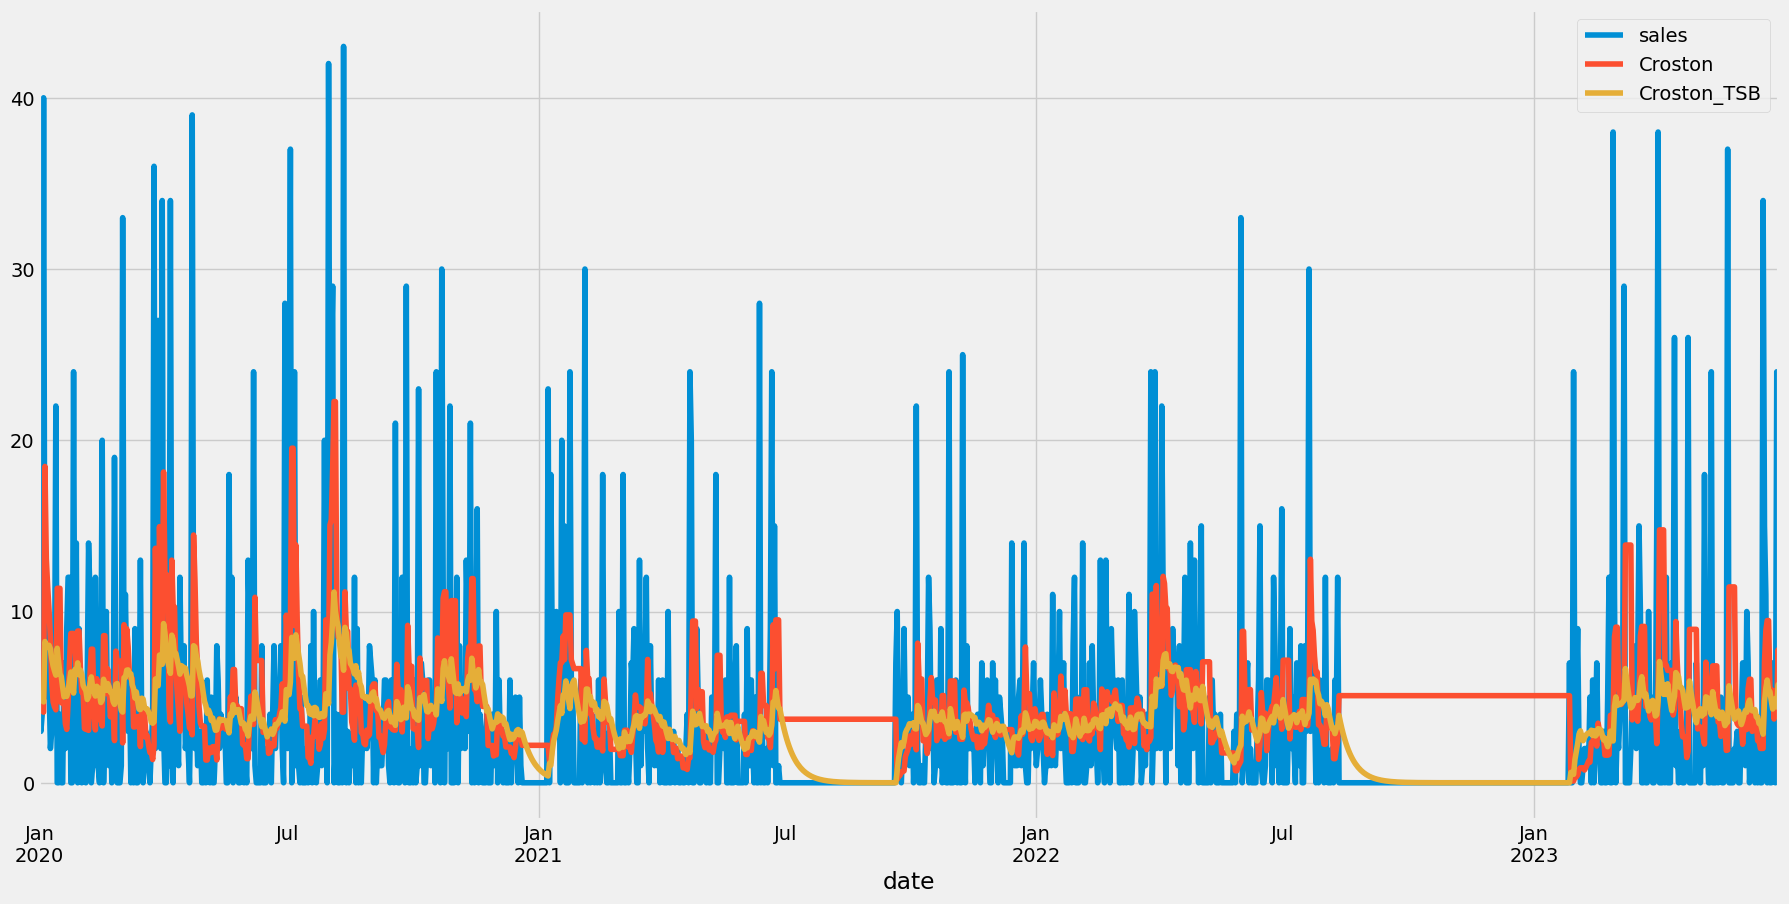

In [21]:
df['Croston_TSB'] = pred_croston_tsb.values
df.set_index('date').plot()

ML Approach

In [22]:
xdat.head(4)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0


<Axes: xlabel='date'>

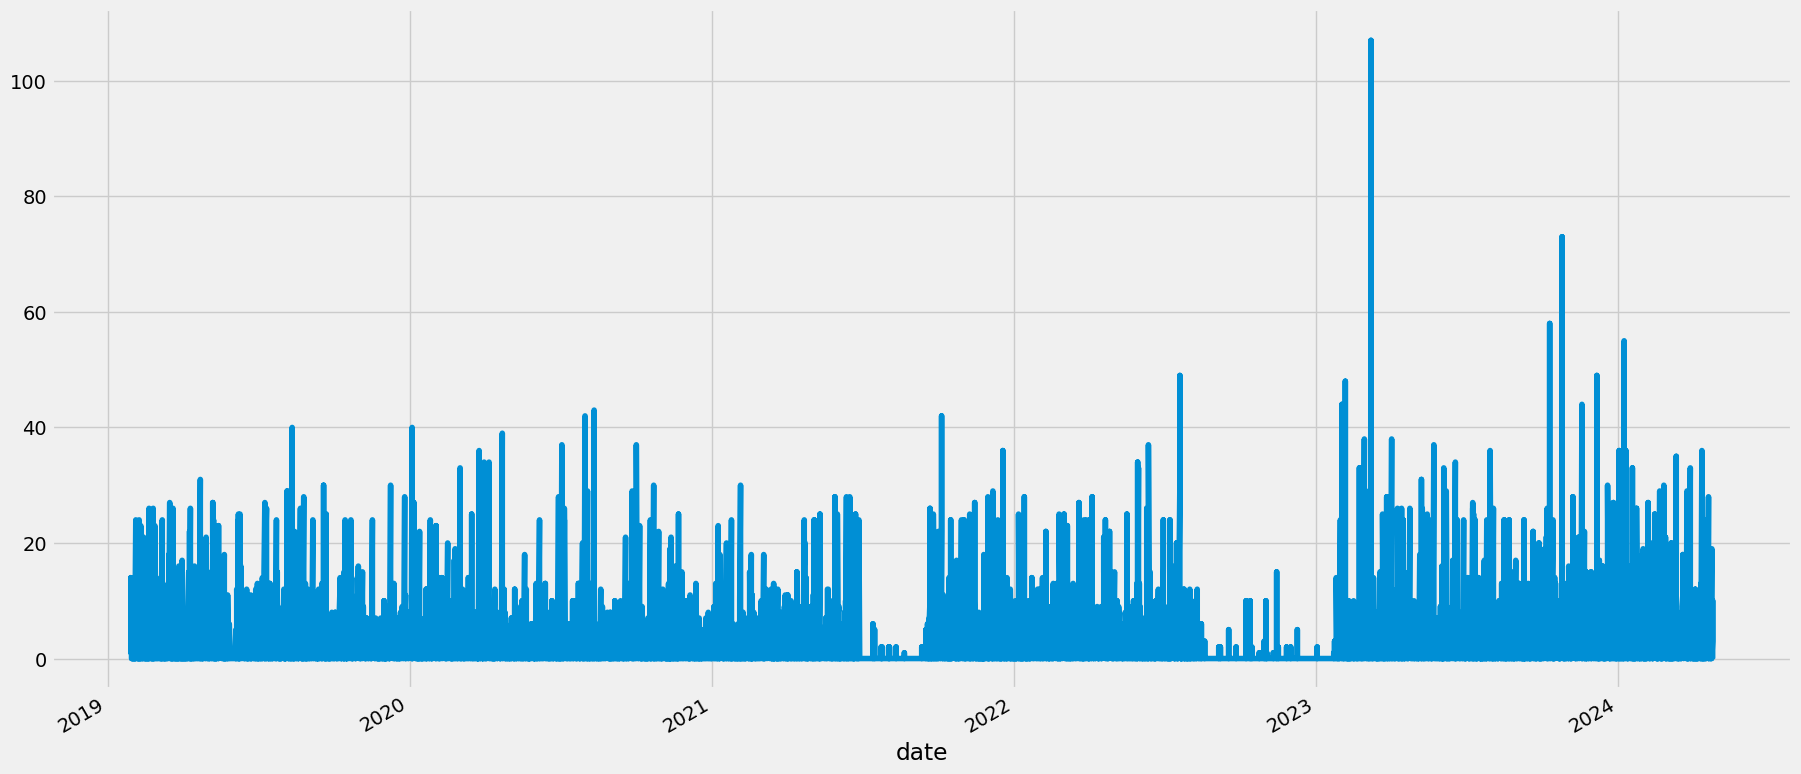

In [23]:
df = xdat.loc[xdat.item_id == 'HOBBIES_1_288' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

<Axes: xlabel='date'>

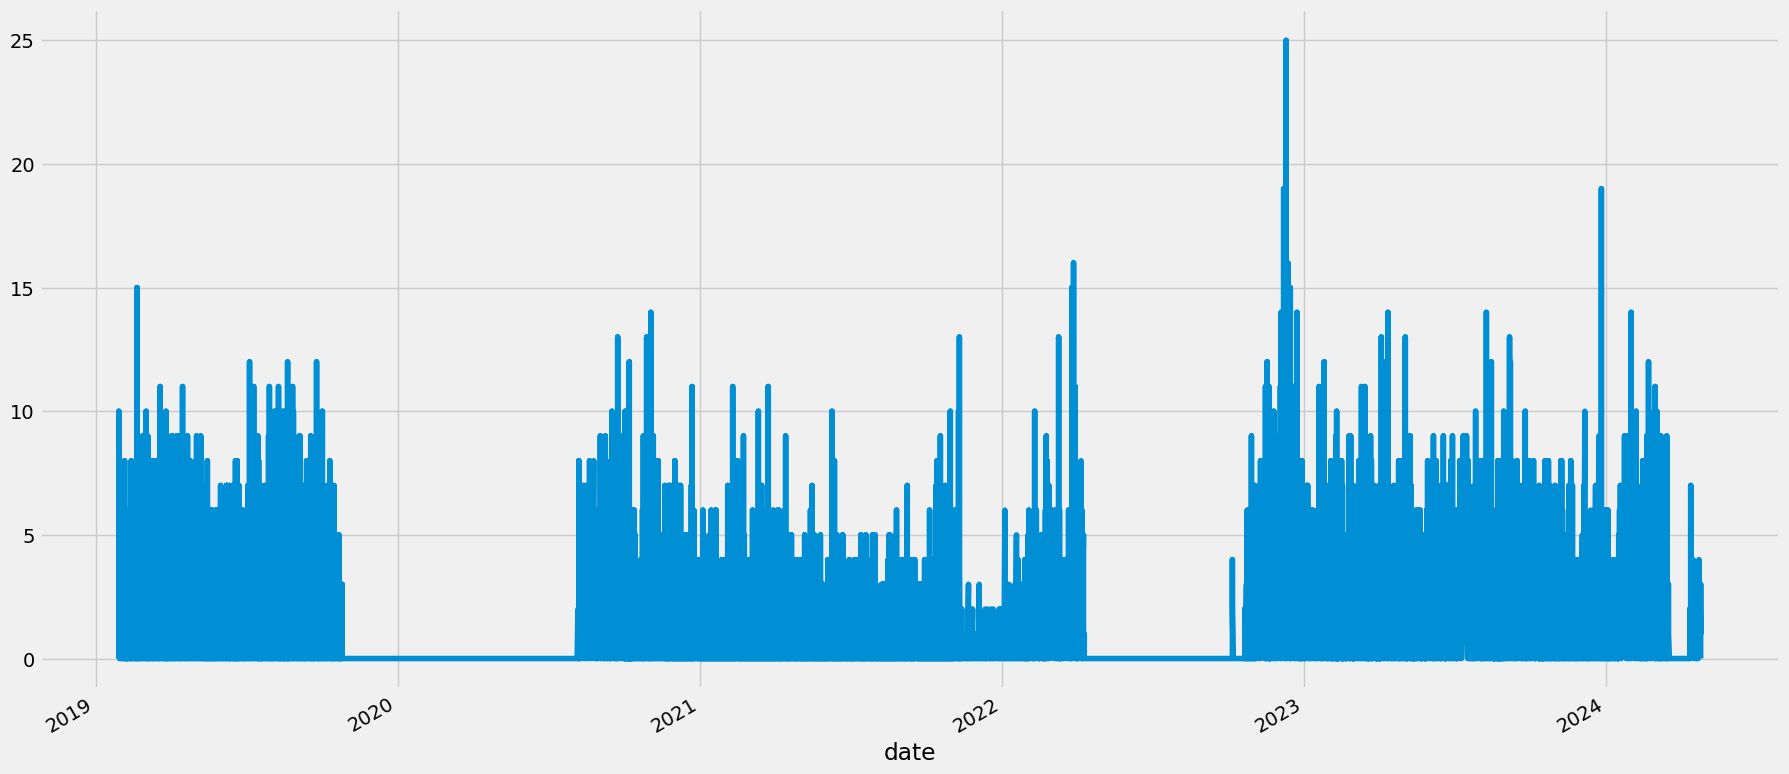

In [24]:
df = xdat.loc[xdat.item_id == 'FOODS_3_823' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

<Axes: xlabel='date'>

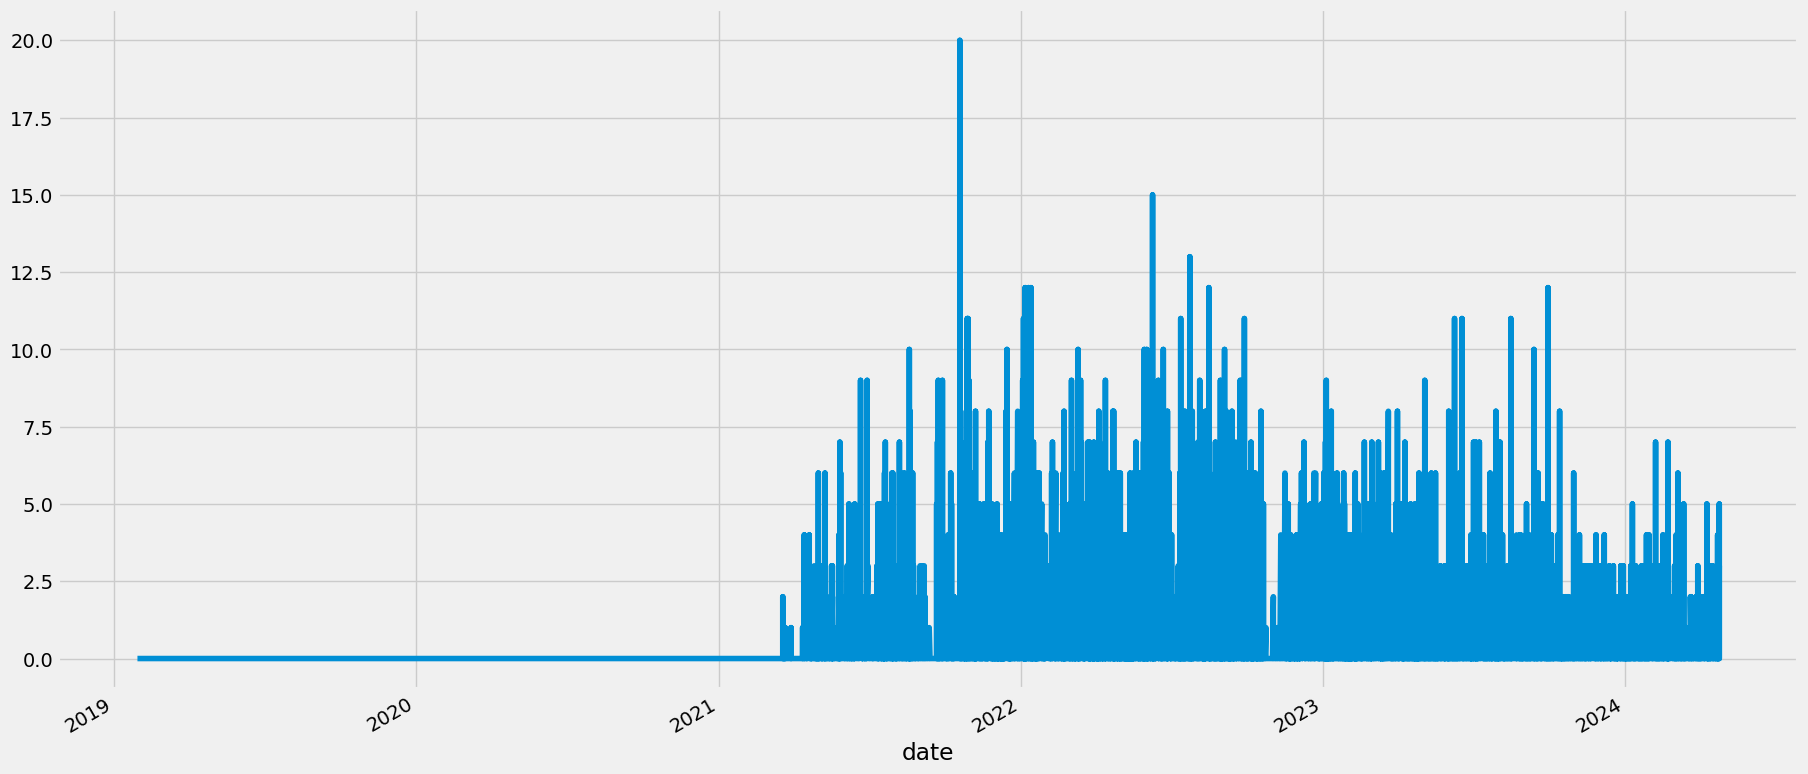

In [25]:
df = xdat.loc[xdat.item_id == 'HOUSEHOLD_2_513' ][['date', 'sales']].copy()
df.set_index('date').sales.plot()

In [26]:
def create_features(dt, lags = [28], wins = [7,28]):
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag).fillna(-1)

    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).fillna(-1)
        
    return dt

xdat = create_features(xdat)

xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,rmean_28_28
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0,-1.0,-1.0,-1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0,-1.0,-1.0,-1.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0,-1.0,-1.0,-1.0


In [27]:
xdat['date'] = pd.to_datetime(xdat["date"])

date_features = {
    "wday": "weekday",
    "week": "isocalendar",
    "month": "month",
    "quarter": "quarter",
    "year": "year",
    "mday": "day",
}

for date_feat_name, date_feat_func in date_features.items():
    if date_feat_name in xdat.columns:
        xdat[date_feat_name] = xdat[date_feat_name].astype("int16")
    else:
        if date_feat_func == "isocalendar":
            xdat[date_feat_name] = getattr(xdat["date"].dt, date_feat_func)().week.astype("int16")
        else:
            xdat[date_feat_name] = getattr(xdat["date"].dt, date_feat_func).astype("int16")


In [28]:
# split into train and test
cutoff = xdat.date.max() - pd.to_timedelta(28, unit = 'D')
xtrain = xdat.loc[xdat.date < cutoff].copy()
xvalid = xdat.loc[xdat.date >= cutoff].copy()

del xdat

xtrain.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA,lag_28,rmean_28_7,rmean_28_28,week,month,quarter,year,mday
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0,-1.0,-1.0,-1.0,5,1,1,2019,29
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0,-1.0,-1.0,-1.0,5,1,1,2019,29
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2019-01-29,1,0,-1.0,-1.0,-1.0,5,1,1,2019,29


In [29]:
ytrain = xtrain['sales'].copy()
yvalid = xvalid['sales'].copy()

xtrain.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)
xvalid.drop(['id', 'wday', 'sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)

In [30]:
dtrain = lgb.Dataset(xtrain , label = ytrain,  free_raw_data=False)
dvalid = lgb.Dataset(xvalid, label = yvalid,   free_raw_data=False)


<Axes: ylabel='Density'>

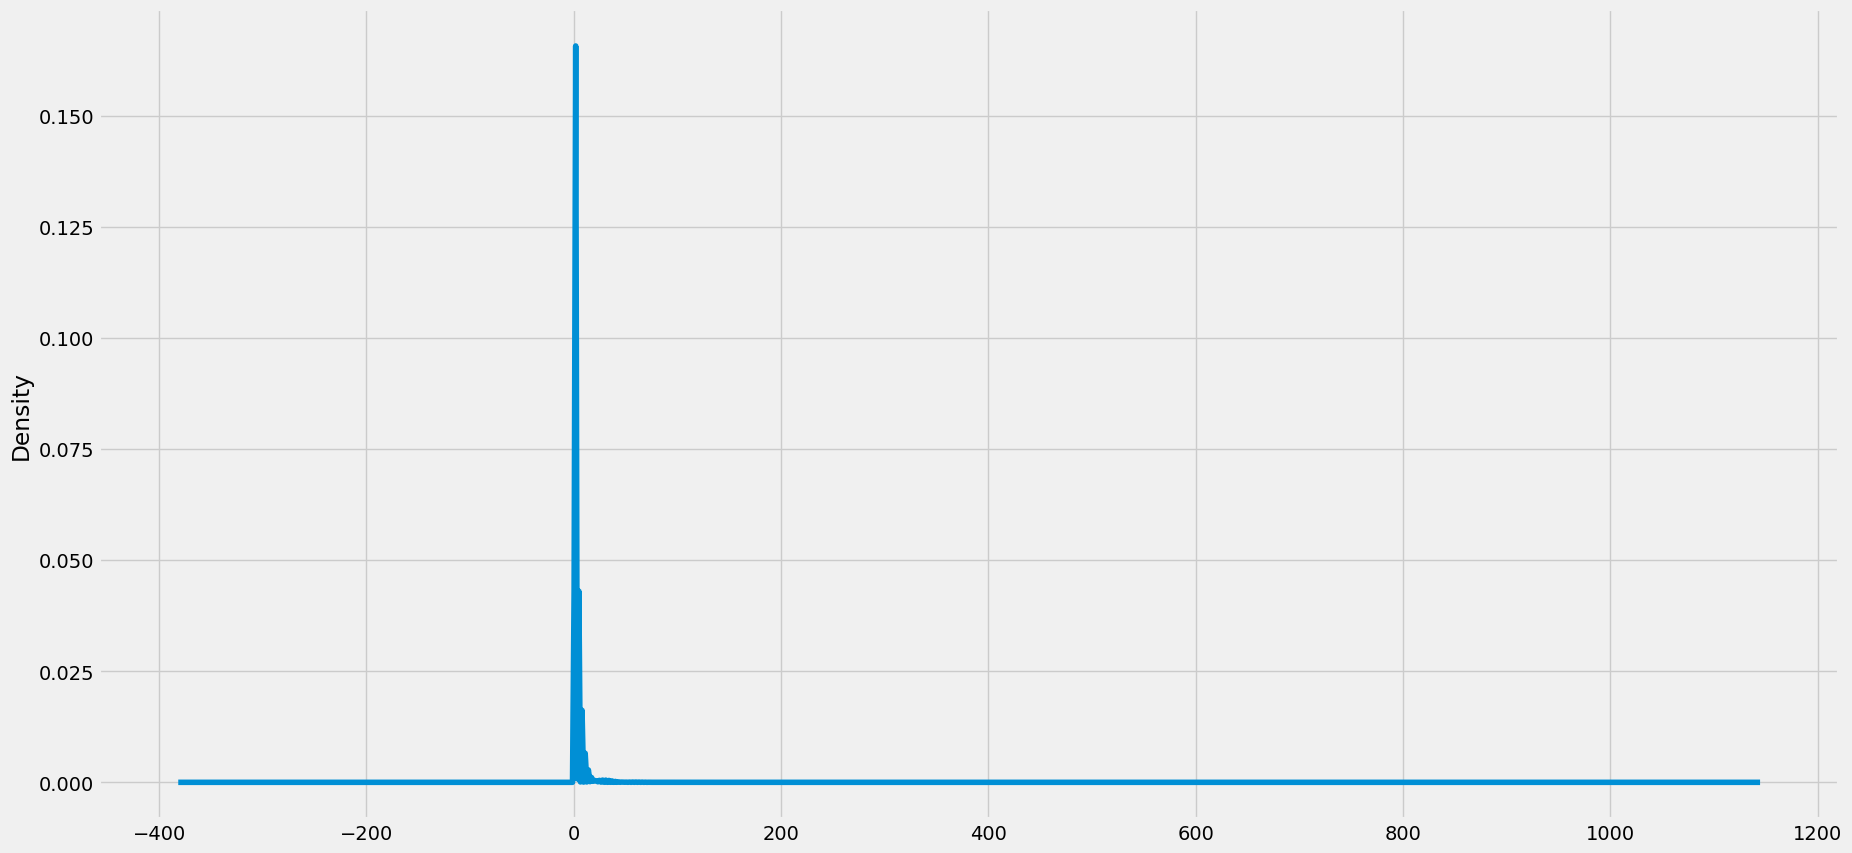

In [31]:
ytrain.plot.density()

In [32]:
params = {
        "objective" : "poisson",
    
        "metric" : "rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 1000,        
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}


m_lgb = lgb.train(params, dtrain, valid_sets = [dtrain, dvalid], 
                  callbacks=[lgb.early_stopping(stopping_rounds=10)])  

/home/user/projects/SAP_AI/env/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
params = {
        "objective" : "tweedie",
    
        "metric" : "rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 1000,        
        'num_leaves': 128,
        "min_data_in_leaf": 50,
}


m_lgb = lgb.train(params, dtrain, valid_sets = [dtrain, dvalid], 
                  callbacks=[lgb.early_stopping(stopping_rounds=10),
                  lgb.verbose_eval = 100]) 